In [1]:
import os
import numpy as np
import pickle
import gym
import time as t
import pandas as pd
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy as MLP_PPO
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy as MLP_DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import seaborn as sns
from explainable.utils import evaluate_policy
#from explainable.envs.deeprmsa_env import shortest_available_path_first_fit
from explainable.dagger import DAgger_Policy
stable_baselines3.__version__ # printing out stable_baselines version used

C:\Users\wanha\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.7.0'

In [2]:
def get_EnvExpert(top_name, k, alg_name, base_log_dir='./tmp/', only_spectrum_obs = False, mean_service_holding_time=10):
    topology_dir = '/topologies/demo/' +  top_name +f'_{k}.h5'
    with open(f'..{topology_dir}', 'rb') as f:
        topology = pickle.load(f)
    assert k <= topology.graph['k_paths']
    
    node_request_probabilities = np.array([1/11, 1/11, 1/11, 1/11,
                                       1/11, 1/11, 1/11, 1/11,
                                       1/11, 1/11, 1/11])

    env_args = dict(topology=topology, seed=10, 
                    allow_rejection=False, # the agent cannot proactively reject a request
                    j=1, # consider only the first suitable spectrum block for the spectrum assignment
                    mean_service_holding_time=mean_service_holding_time, # value is not set as in the paper to achieve comparable reward values
                    episode_length=50, node_request_probabilities=node_request_probabilities, num_spectrum_resources = 358)

    # Create log dir
    log_dir = "./tmp/deeprmsa-dqn-sbpp-agent-{}-cost239/".format(mean_service_holding_time)
    env = gym.make('DeepRMSA-v0', **env_args)

    # logs will be saved in log_dir/monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking probabilities
    env = Monitor(env, log_dir + 'testing', info_keywords=('episode_service_blocking_rate','bit_rate_blocking_rate','failure', 'episode_failure',
                        'failure_slots','episode_failure_slots', 
                        'failure_disjointness','episode_failure_disjointness', 'failure_shared_disjointness',
                        'episode_failure_shared_disjointness','shared_counter','episode_shared_counter', 'dpp_counter',
                        'episode_dpp_counter','compactness', 'throughput', 'available_slots_working', 'available_slots_backup'))
    
    expert = DQN.load(log_dir +'best_model')
        
    return env, expert

In [3]:
alg_name = 'DQN'
top_name = 'cost239'
k_path = 10
traffics = [100, 200, 300, 400, 500]
holding_time = [10, 20, 30, 40, 50]
max_depths = [5, 10, 15, 20, 25]
n_eval_episodes = 2000
use_heuristic_trainer = False

In [ ]:
from sklearn import tree
from explainable.dagger import DAgger
from explainable.utils import collect_transitions

start = t.time()
env, expert = get_EnvExpert(top_name, k_path, alg_name, mean_service_holding_time=10)
demostrations = collect_transitions(expert, env, 20000)
end = t.time()
timer = end - start
timer = round(timer/60,2)

print(f"Load envrionment and collect transitions done with duration of {timer} minutes")

for max_depth in max_depths: 
    start = t.time()
    # Decision Trees Dagger Trainer:
    tree_regr = tree.DecisionTreeClassifier(max_depth=max_depth) # depth is set only for visualization purposes
    tree_dagger = DAgger(expert, tree_regr, env, demostrations.copy(), max_depth=max_depth)

    # Training the student policy:
    tree_dagger.train(expert, env)
    
    # saving the student policy:
    save_dir = "./tmp_DT_max_depth/" + f'cost239_{k_path}_{max_depth}/'
    tree_dagger.policy.save(save_dir)
    end = t.time()
    timer = end - start
    timer = round(timer/60,2)
    print(f'done for DTClassifier with depth of {max_depth} and duration of {timer} minutes')

In [4]:
rewards = {
    'Student':[],
    'Agent':[]       
} 
blocking_rates = {
    'Student':[],
    'Agent':[]  
} 
student_accuracy = {
    'Student':[],
    'Agent':[] 
}

start = t.time()
env, expert = get_EnvExpert(top_name,k_path, alg_name, mean_service_holding_time=10)
Agent_reward, _, Agent_df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)
end = t.time()
timer = end - start
timer = round(timer/60,2)

print(f"mean reward agent is {Agent_reward} calculated with duration of {timer} minutes")

for md in max_depths:  
    for key in rewards:
        if key == 'Student':
            start = t.time()
            policy = DAgger_Policy.load(f'./tmp_DT_max_depth/cost239_{k_path}_{md}/model.h5',env.observation_space,env.action_space)
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = policy, return_dataframe=True)
            end = t.time()
            timer = end - start
            timer = round(timer/60,2)
            accuracy = 100*(1 - (abs(Agent_reward - mean_reward)/Agent_reward))
            print(f'Done for {key} with expert mean_reward = {mean_reward} with duration of {timer} minutes and accuracy of {accuracy}')
        elif key == 'Agent':
            mean_reward = Agent_reward
            df = Agent_df
            accuracy = 100
        else:
            raise Exception("\n\nSorry, key not found")

        rewards[key].append(mean_reward)
        student_accuracy[key].append(accuracy)
        blocking_rates[key].append(df['service_blocking_rate'][len(df['service_blocking_rate'])-1])

mean reward agent is 72.125 calculated with duration of 11.89 minutes
Done for Student with expert mean_reward = 62.4935 with duration of 7.54 minutes and accuracy of 86.64610051993067
Done for Student with expert mean_reward = 69.5385 with duration of 8.01 minutes and accuracy of 96.41386481802427
Done for Student with expert mean_reward = 71.317 with duration of 8.13 minutes and accuracy of 98.8797227036395
Done for Student with expert mean_reward = 69.5265 with duration of 8.04 minutes and accuracy of 96.39722703639515
Done for Student with expert mean_reward = 69.635 with duration of 8.06 minutes and accuracy of 96.54766031195841


In [5]:
os.makedirs('./plots_DT_max_depth/', exist_ok=True)

df_r = pd.DataFrame(rewards)
df_r.to_csv(f'./plots_DT_max_depth/rewards_{k_path}_md.csv')
df_r = pd.DataFrame(blocking_rates)
df_r.to_csv(f'./plots_DT_max_depth/blocking_rates_{k_path}_md.csv')
df_r = pd.DataFrame(student_accuracy)
df_r.to_csv(f'./plots_DT_max_depth/student_accuracy_{k_path}_md.csv')

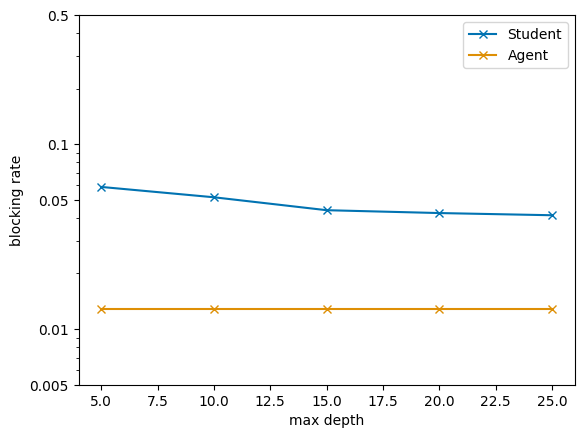

In [6]:
base_output_dir = './plots_DT_max_depth/blocking_rate/'
colors = sns.color_palette("colorblind")

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(rewards):
    plt.plot(max_depths, blocking_rates[key], 'x-', label=key, color=colors[i])
plt.xlabel("max depth")
plt.ylabel("blocking rate")
plt.legend()
plt.yscale('log')
plt.yticks(ticks=[5*10e-4, 10e-3,5*10e-3,10e-2,5*10e-2],labels=[ 5*10e-4, 10e-3,5*10e-3,10e-2,5*10e-2])
# plt.yticks(ticks=[x/100 for x in range(1, 25,5)],labels=[x/100 for x in range(1, 25,5)])
plt.savefig(output_dir + f'{top_name}_{k_path}.png')
plt.show()

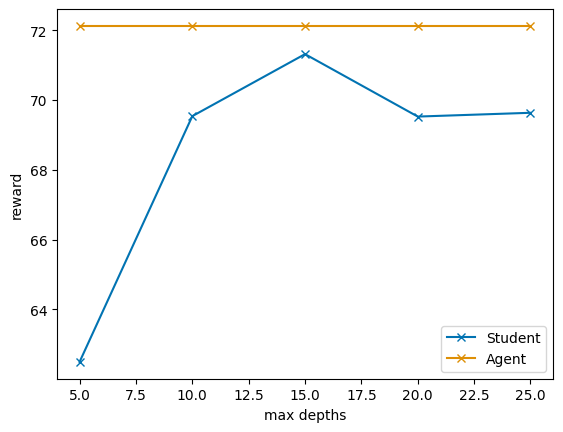

In [7]:
base_output_dir = './plots_DT_max_depth/rewards/'

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(rewards):
    plt.plot(max_depths, rewards[key], 'x-', label=key, color=colors[i])
plt.xlabel("max depths")
plt.ylabel("reward")
plt.legend()
plt.savefig(output_dir + f'{top_name}_{k_path}.png')
plt.show()

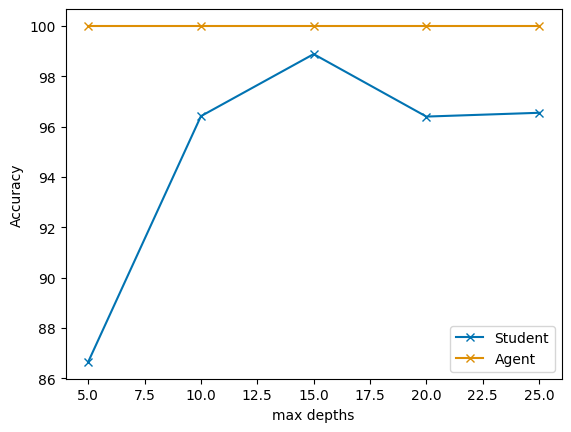

In [8]:
base_output_dir = './plots_DT_max_depth/student_accuracy/'

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(rewards):
    plt.plot(max_depths, student_accuracy[key], 'x-', label=key, color=colors[i])
plt.xlabel("max depths")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(output_dir + f'{top_name}_{k_path}.png')
plt.show()